## Pool characteristics for tracers in BARKLEY run

Lin
Sal
Nit
Oxy
Sil
Pho
NAc
Met

In [1]:
import cmocean as cmo
from netCDF4 import Dataset
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
import xarray as xr
import canyon_tools.readout_tools as rout
import canyon_tools.savitzky_golay as sg

In [2]:
sns.set_context('notebook')
sns.set_style('whitegrid')

In [3]:
# Grid, state and tracers datasets of base case
grid_file = '/data/kramosmu/results/TracerExperiments/BARKLEY/run01/gridGlob.nc'

state_file = '/data/kramosmu/results/TracerExperiments/BARKLEY/run01/stateGlob.nc' 

ptracers_file = '/data/kramosmu/results/TracerExperiments/BARKLEY/run01/ptracersGlob.nc'

ptracers_fileNoC = '/data/kramosmu/results/TracerExperiments/BARKLEY/run02/ptracersGlob.nc'

In [4]:
with Dataset(grid_file, 'r') as nbl:
    Z = nbl.variables['RC'][:]
    X = nbl.variables['X'][:]
    Y = nbl.variables['Y'][:]
    hFacC = nbl.variables['HFacC'][:]
    rA = nbl.variables['rA'][:]
    Depth = nbl.variables['Depth'][:]
    
with Dataset(state_file, 'r') as nbl:
    iters = nbl.variables['iter'][:]
 

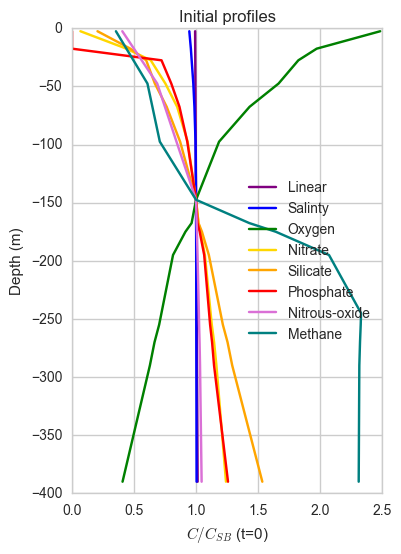

In [5]:
labels = ['Linear','Salinty','Oxygen','Nitrate','Silicate','Phosphate','Nitrous-oxide','Methane']
colours = ['purple','blue','green','gold','orange','red','orchid','teal']
tracer_names = ['Tr01','Tr02','Tr03','Tr04','Tr05','Tr06','Tr07','Tr08']

fig,ax = plt.subplots(1,1,figsize=(4,6))

with Dataset(ptracers_file, 'r') as nbl:
    for trac, lab, col in zip(tracer_names, labels, colours):
        profile = nbl.variables[trac][0,0:50,50,180]
        C0 = profile[29]
        ax.plot(profile/C0,Z[0:50],color=col,label=lab)

ax.set_xlabel(r'$C/C_{SB}$ (t=0)')
ax.set_ylabel('Depth (m)')
ax.set_title('Initial profiles')
ax.legend(loc=0)

In [6]:
def mask2DCanyon(bathy, sbdepth=-152.5):
    '''Mask out the canyon from the shelf.
    bathy : depths 2D array from the grid file
    sbdepth: shelf depth, always negative float 
    Returns mask'''
    
    bathyMasked = np.ma.masked_less(-bathy, -152.5)
    return(bathyMasked.mask)

def ConcAreaFunc(Tr, hfac, ra, bathy, sbdepth=-152.5):
    '''Tr: Tracer field (nt,nz,ny,nx)
       hfac: fraction of open cell at center (nz,ny,nx)
       ra: array of cell horizontal areas (ny,nx)
       bathy : depths 2D array from the grid file (ny,nx)
       sbdepth: shelf break depth (negative value)
       
       RETURNS:
       ConcArea = concentration at cell closest to bottom times its area (nt,ny,nx)
       Conc = cocnetration near bottom (nt,ny,nx)'''
    
    ConcArea = np.empty((360,616))
    Conc = np.empty((360,616))
    ConcFiltered = np.empty((360,616))
    Area = np.empty((360,616))
    BottomInd = np.argmax(hfac[::-1,:,:]>0.0,axis=0) # start looking for first no-land cell from the bottom up.
    BottomInd = np.ones(np.shape(BottomInd))*89 - BottomInd # Get index of unreversed z axis
    
    for j in range(616):
        for i in range(360):
            TrBottom = Tr[BottomInd[i,j],i,j]
            if TrBottom > 0.0:
                ConcArea[i,j] = TrBottom*ra[i,j]
                Conc[i,j] = TrBottom
                Area[i,j] = ra[i,j]
            else:
                ConcArea[i,j] = np.NaN
                Conc[i,j] = np.NaN
                Area[i,j] = np.NaN
                    
        # Filter step noise
        ConcFiltered[:,j] = sg.savitzky_golay(Conc[:,j], 7,3) 
                
    maskShelf = mask2DCanyon(bathy, sbdepth)
    maskShelf = np.expand_dims(maskShelf,0) # expand along time dimension
    maskShelf = maskShelf + np.zeros(Conc.shape)
    
    return (ConcArea,
            np.ma.masked_array(ConcFiltered, mask=maskShelf),
            Area,
           )

def PlotBAC(ax,ConcFilt,xslice,yslice,cmap=cmo.cm.tempo, maxCM=9999, minCM=9999):
    
    BAC = ConcFilt[yslice,xslice]
    
    if maxCM == 9999:
        maxCM = np.nanmax(ConcFilt[yslice,xslice])
        minCM = np.nanmin(ConcFilt[yslice,xslice])

    mesh = ax.contourf(X[xslice]/1000,Y[yslice]/1000,BAC,21, 
                      vmax=maxCM, 
                      vmin=minCM,
                      cmap=cmap)
    
    #cbar_ax = fig.add_axes([0.9, 0.327, 0.015, 0.252])
    #cb=fig.colorbar(mesh, cax=cbar_ax,ticks=[5.2,6.2,7.2,8.2,9.2,10.2],format='%.1f')
    #cb.ax.yaxis.set_tick_params(pad=1)
    fig.colorbar(mesh,ax=ax)
    ax.set_axis_bgcolor((205/255.0, 201/255.0, 201/255.0))
    
    SB = ax.contour(X[xslice]/1000,Y[yslice]/1000,
                    Depth[yslice,xslice],
                    [150.0],
                    colors='0.1',linewidths=[0.75] )
    ax.tick_params(axis='x', pad=1)
    ax.tick_params(axis='y', pad=1)


In [7]:
ConcFilt1 = np.ma.empty((3,360,616)) # saving 3 time outputs, nx,ny
ConcFilt2 = np.ma.empty((3,360,616))
ConcFilt3 = np.ma.empty((3,360,616))
ConcFilt4 = np.ma.empty((3,360,616))
ConcFilt5 = np.ma.empty((3,360,616))
ConcFilt6 = np.ma.empty((3,360,616))
ConcFilt7 = np.ma.empty((3,360,616))
ConcFilt8 = np.ma.empty((3,360,616))

concList = [ConcFilt1,ConcFilt2,ConcFilt3,ConcFilt4,ConcFilt5,ConcFilt6,ConcFilt7,ConcFilt8]


for trac,conc in zip(tracer_names, concList):
    with Dataset(ptracers_file, 'r') as nbl:
        ConcArea, conc[0,:,:], Area = ConcAreaFunc(nbl.variables[trac][0,:,:,:],hFacC,rA,Depth)
        ConcArea, conc[1,:,:], Area = ConcAreaFunc(nbl.variables[trac][7,:,:,:],hFacC,rA,Depth)
        ConcArea, conc[2,:,:], Area = ConcAreaFunc(nbl.variables[trac][14,:,:,:],hFacC,rA,Depth)
    
    print('done with tracer %s' %trac )

/home/kramosmu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:30: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


done with tracer Tr01


KeyboardInterrupt: 

In [8]:
# General input
nx = 616
ny = 360
nz = 90
nt = 19 # t dimension size 

yslice = slice(225,360)
xslice = slice(0,616)


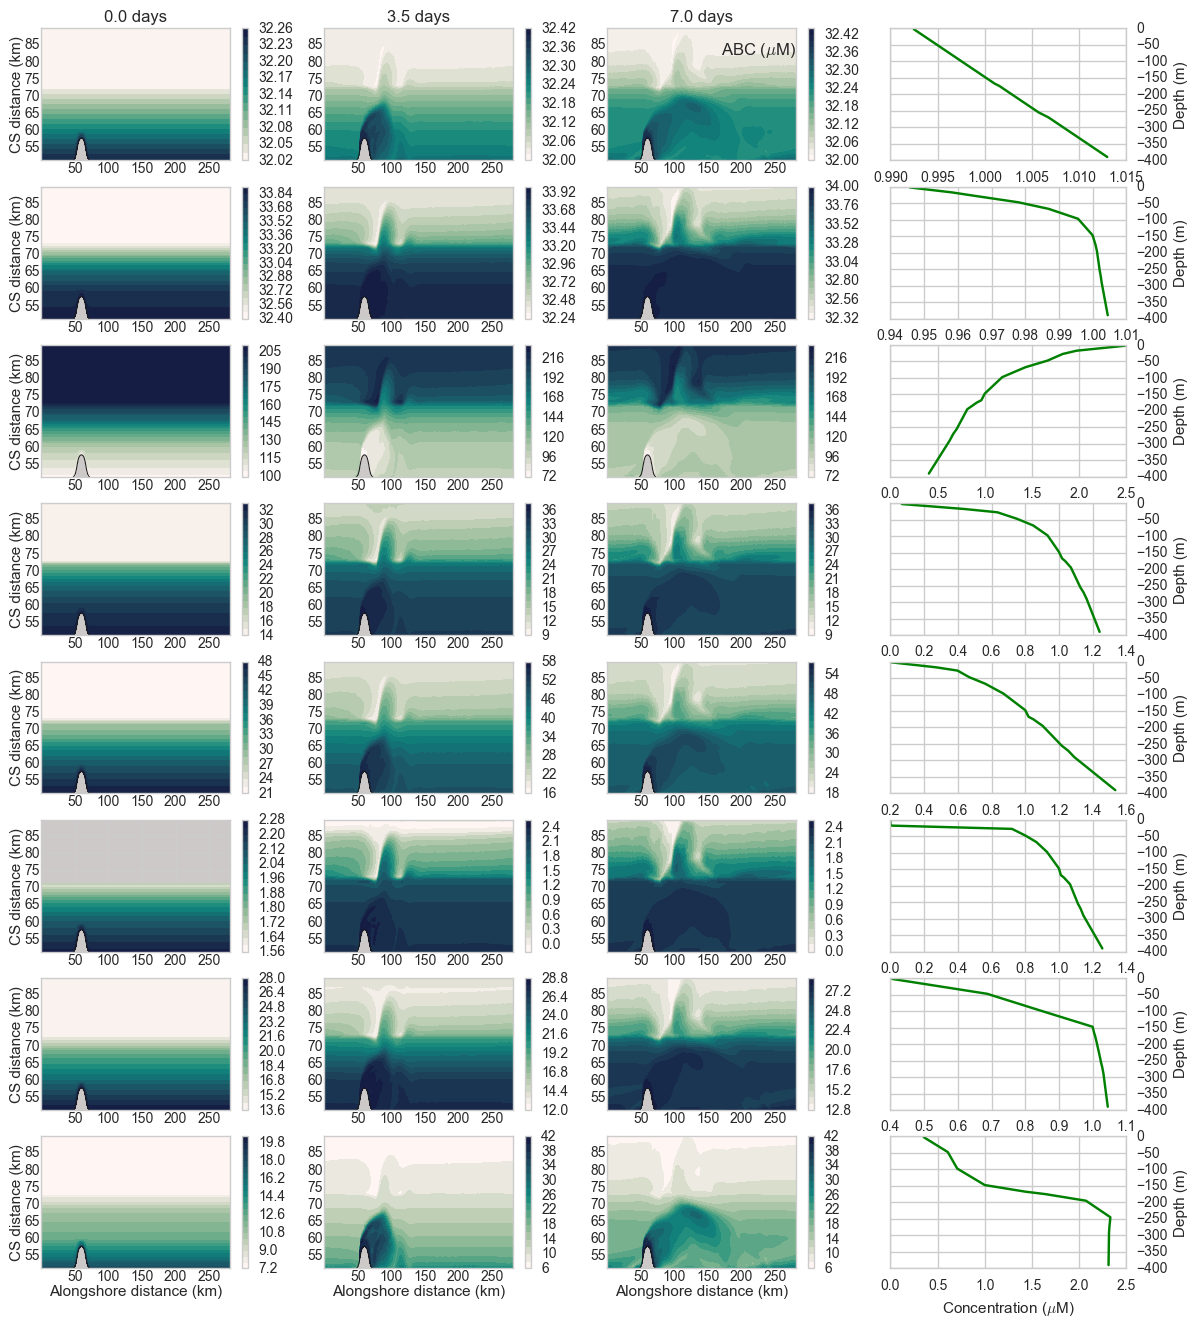

In [17]:
fig, ax = plt.subplots(8,4,figsize=(14,16))

timesInd = [0,7,14]   # days I saved above

for ii,tt in zip(range(0,3),timesInd):
    
    PlotBAC(ax[0,ii],ConcFilt1[ii,:,:],xslice,yslice)
    PlotBAC(ax[1,ii],ConcFilt2[ii,:,:],xslice,yslice)
    PlotBAC(ax[2,ii],ConcFilt3[ii,:,:],xslice,yslice)
    PlotBAC(ax[3,ii],ConcFilt4[ii,:,:],xslice,yslice)
    PlotBAC(ax[4,ii],ConcFilt5[ii,:,:],xslice,yslice)
    PlotBAC(ax[5,ii],ConcFilt6[ii,:,:],xslice,yslice)
    PlotBAC(ax[6,ii],ConcFilt7[ii,:,:],xslice,yslice)
    PlotBAC(ax[7,ii],ConcFilt8[ii,:,:],xslice,yslice)
    
    ax[0,ii].set_title('%1.1f days' % ((iters[tt]*40)/(3600*24)))

with Dataset(ptracers_file, 'r') as nbl:
    for trac, ii in zip(tracer_names, range(len(tracer_names))):
        profile = nbl.variables[trac][0,0:50,50,180]
        C0 = profile[29]
        ax[ii,3].plot(profile/C0,Z[0:50],color='green')
        ax[ii,3].yaxis.tick_right()
        ax[ii,3].yaxis.set_label_position("right")
        ax[ii,3].set_ylabel('Depth (m)')
        ax[ii,0].set_ylabel('CS distance (km)',labelpad=0.3)

ax[7,3].set_xlabel(r'Concentration ($\mu$M)')

    
ax[0,2].text(0.6,0.8,'ABC ($\mu$M)',transform=ax[0,2].transAxes)
ax[7,0].set_xlabel('Alongshore distance (km)',labelpad=0.3)
ax[7,1].set_xlabel('Alongshore distance (km)',labelpad=0.3)
ax[7,2].set_xlabel('Alongshore distance (km)',labelpad=0.3)


In [18]:
ConcFilt1NoC = np.ma.empty((3,360,616)) # saving 3 time outputs, nx,ny
ConcFilt2NoC = np.ma.empty((3,360,616))
ConcFilt3NoC = np.ma.empty((3,360,616))
ConcFilt4NoC = np.ma.empty((3,360,616))
ConcFilt5NoC = np.ma.empty((3,360,616))
ConcFilt6NoC = np.ma.empty((3,360,616))
ConcFilt7NoC = np.ma.empty((3,360,616))
ConcFilt8NoC = np.ma.empty((3,360,616))

concList = [ConcFilt1NoC,ConcFilt2NoC,ConcFilt3NoC,ConcFilt4NoC,ConcFilt5NoC,ConcFilt6NoC,ConcFilt7NoC,ConcFilt8NoC]


for trac,conc in zip(tracer_names, concList):
    with Dataset(ptracers_fileNoC, 'r') as nbl:
        ConcArea, conc[0,:,:], Area = ConcAreaFunc(nbl.variables[trac][0,:,:,:],hFacC,rA,Depth)
        ConcArea, conc[1,:,:], Area = ConcAreaFunc(nbl.variables[trac][7,:,:,:],hFacC,rA,Depth)
        ConcArea, conc[2,:,:], Area = ConcAreaFunc(nbl.variables[trac][14,:,:,:],hFacC,rA,Depth)
    
    print('done with tracer %s' %trac )

/home/kramosmu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:30: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


done with tracer Tr01
done with tracer Tr02
done with tracer Tr03
done with tracer Tr04
done with tracer Tr05
done with tracer Tr06
done with tracer Tr07
done with tracer Tr08


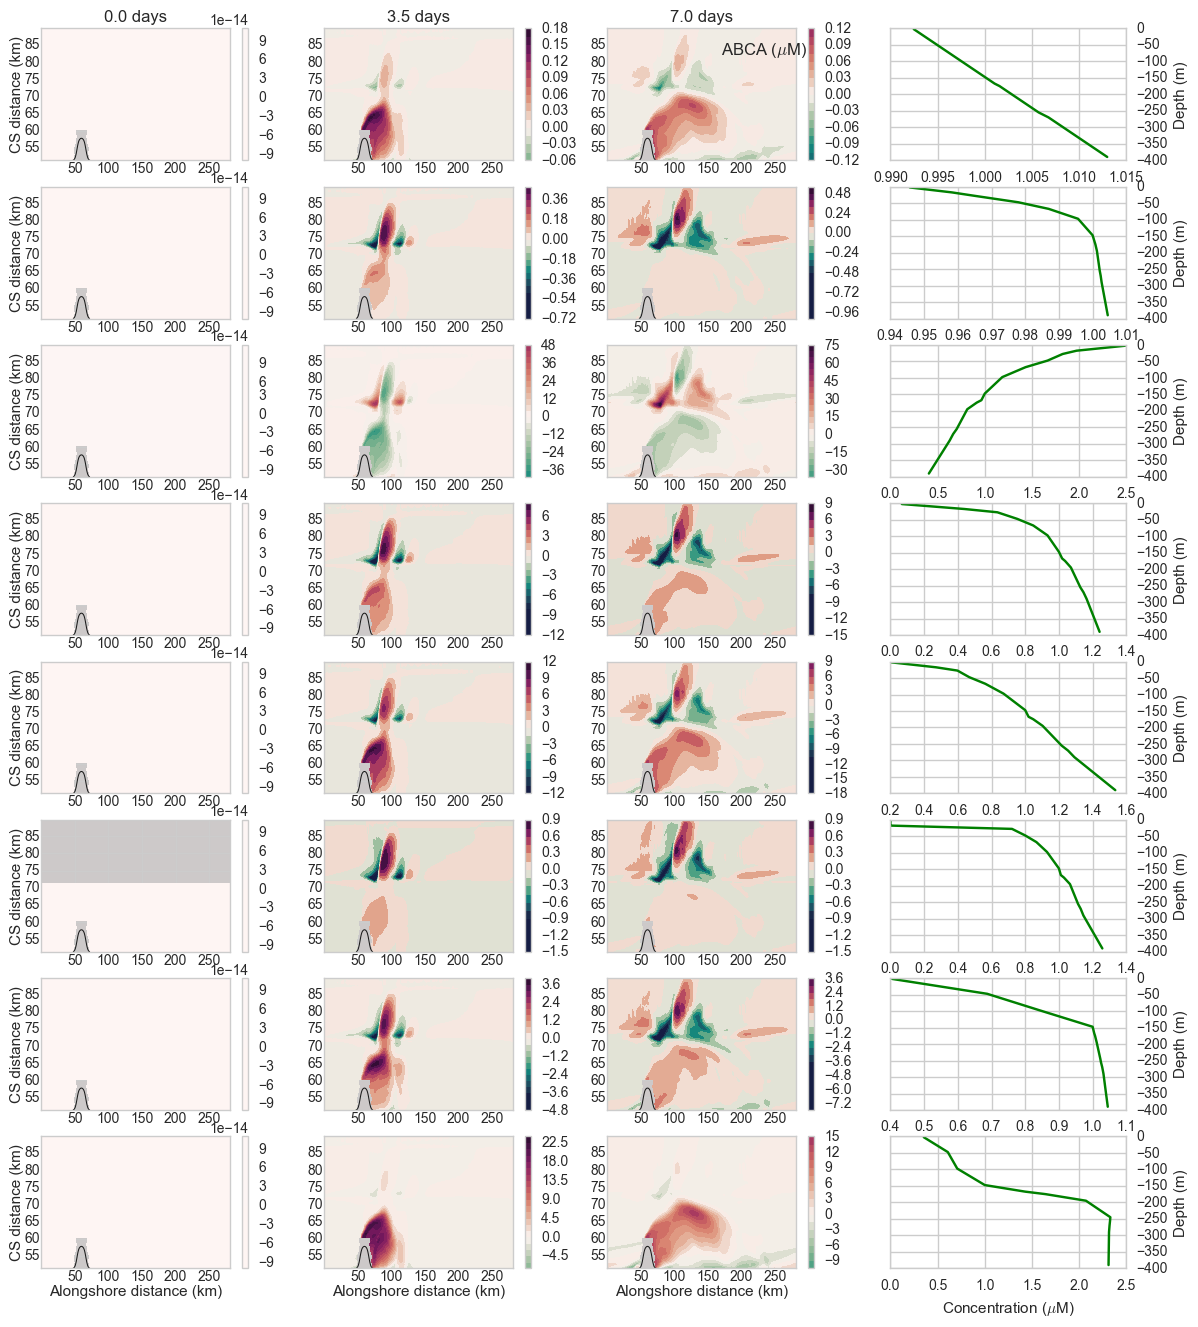

In [20]:
fig, ax = plt.subplots(8,4,figsize=(14,16))

timesInd = [0,7,14]   # days I saved above

for ii,tt in zip(range(0,3),timesInd):
    
    maxCM = np.nanmax((ConcFilt1-ConcFilt1NoC)[:,yslice,xslice])
    minCM = - maxCM
    PlotBAC(ax[0,ii],ConcFilt1[ii,:,:]-ConcFilt1NoC[ii,:,:],xslice,yslice,cmap=cmo.cm.curl,maxCM=maxCM,minCM=minCM)
    
    maxCM = np.nanmax((ConcFilt2-ConcFilt2NoC)[:,yslice,xslice])
    minCM = - maxCM
    PlotBAC(ax[1,ii],ConcFilt2[ii,:,:]-ConcFilt2NoC[ii,:,:],xslice,yslice,cmap=cmo.cm.curl,maxCM=maxCM,minCM=minCM)
    
    maxCM = np.nanmax((ConcFilt3-ConcFilt3NoC)[:,yslice,xslice])
    minCM = - maxCM
    PlotBAC(ax[2,ii],ConcFilt3[ii,:,:]-ConcFilt3NoC[ii,:,:],xslice,yslice,cmap=cmo.cm.curl,maxCM=maxCM,minCM=minCM)
    
    maxCM = np.nanmax((ConcFilt4-ConcFilt4NoC)[:,yslice,xslice])
    minCM = - maxCM
    PlotBAC(ax[3,ii],ConcFilt4[ii,:,:]-ConcFilt4NoC[ii,:,:],xslice,yslice,cmap=cmo.cm.curl,maxCM=maxCM,minCM=minCM)
    
    maxCM = np.nanmax((ConcFilt5-ConcFilt5NoC)[:,yslice,xslice])
    minCM = - maxCM
    PlotBAC(ax[4,ii],ConcFilt5[ii,:,:]-ConcFilt5NoC[ii,:,:],xslice,yslice,cmap=cmo.cm.curl,maxCM=maxCM,minCM=minCM)
    
    maxCM = np.nanmax((ConcFilt6-ConcFilt6NoC)[:,yslice,xslice])
    minCM = - maxCM
    PlotBAC(ax[5,ii],ConcFilt6[ii,:,:]-ConcFilt6NoC[ii,:,:],xslice,yslice,cmap=cmo.cm.curl,maxCM=maxCM,minCM=minCM)
    
    maxCM = np.nanmax((ConcFilt7-ConcFilt7NoC)[:,yslice,xslice])
    minCM = - maxCM 
    PlotBAC(ax[6,ii],ConcFilt7[ii,:,:]-ConcFilt7NoC[ii,:,:],xslice,yslice,cmap=cmo.cm.curl,maxCM=maxCM,minCM=minCM)
   
    maxCM = np.nanmax((ConcFilt8-ConcFilt8NoC)[:,yslice,xslice])
    minCM = - maxCM 
    PlotBAC(ax[7,ii],ConcFilt8[ii,:,:]-ConcFilt8NoC[ii,:,:],xslice,yslice,cmap=cmo.cm.curl,maxCM=maxCM,minCM=minCM)
   
    ax[0,ii].set_title('%1.1f days' % ((iters[tt]*40)/(3600*24)))

with Dataset(ptracers_file, 'r') as nbl:
    for trac, ii in zip(tracer_names, range(len(tracer_names))):
        profile = nbl.variables[trac][0,0:50,50,180]
        C0 = profile[29]
        ax[ii,3].plot(profile/C0,Z[0:50],color='green')
        ax[ii,3].yaxis.tick_right()
        ax[ii,3].yaxis.set_label_position("right")
        ax[ii,3].set_ylabel('Depth (m)')
        ax[ii,0].set_ylabel('CS distance (km)',labelpad=0.3)

ax[7,3].set_xlabel(r'Concentration ($\mu$M)')

    
ax[0,2].text(0.6,0.8,'ABCA ($\mu$M)',transform=ax[0,2].transAxes)
ax[7,0].set_xlabel('Alongshore distance (km)',labelpad=0.3)
ax[7,1].set_xlabel('Alongshore distance (km)',labelpad=0.3)
ax[7,2].set_xlabel('Alongshore distance (km)',labelpad=0.3)



## Plot for OSM 2018 talk

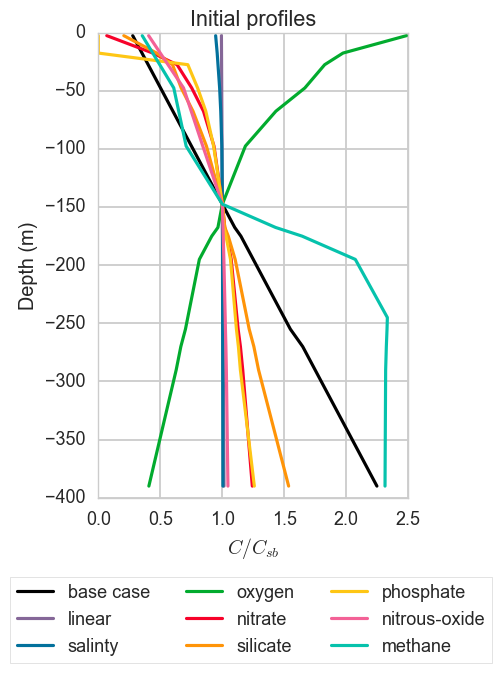

In [16]:
sns.set_context('talk')

tracer_names = ['Tr01','Tr02','Tr03','Tr04','Tr05','Tr06','Tr07','Tr08']
colours = ['dark lavender','ocean blue','kelly green','cherry red','tangerine','golden yellow','medium pink','turquoise']
labels = ['linear','salinty','oxygen','nitrate','silicate','phosphate','nitrous-oxide','methane']

fig,ax = plt.subplots(1,1,figsize=(4,6))

with Dataset('/data/kramosmu/results/TracerExperiments/CNTDIFF/run38/ptracersGlob.nc', 'r') as nbl:
    profile = nbl.variables['Tr1'][0,0:50,50,180]
    C0 = profile[29]
    ax.plot(profile/C0,Z[0:50],color=sns.xkcd_rgb['black'],label='base case')


with Dataset(ptracers_file, 'r') as nbl:
    for trac, lab, col in zip(tracer_names, labels, colours):
        profile = nbl.variables[trac][0,0:50,50,180]
        C0 = profile[29]
        ax.plot(profile/C0,Z[0:50],color=sns.xkcd_rgb[col],label=lab)

ax.set_xlabel(r'$C/C_{sb}$')
ax.set_ylabel('Depth (m)')
ax.set_title('Initial profiles')
ax.legend(bbox_to_anchor=(1.3,-0.15), ncol = 3, frameon=True)
plt.savefig('Barkley_ini_profiles.eps', format='eps', bbox_inches='tight', transparent=True)

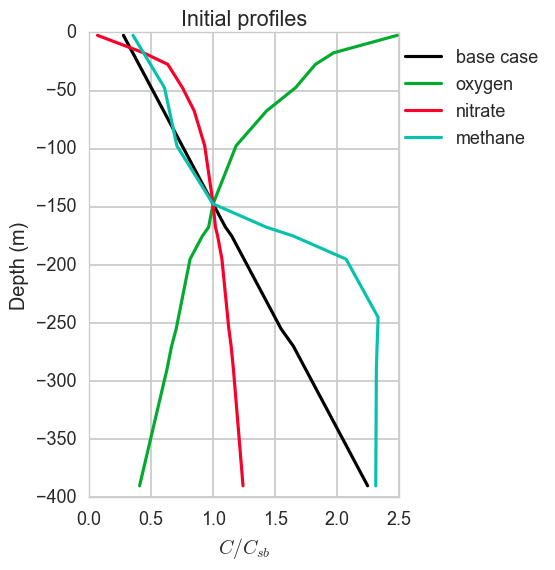

In [17]:
sns.set_context('talk')

tracer_names = ['Tr03','Tr04','Tr08']
colours = ['kelly green','cherry red','turquoise']
labels = ['oxygen','nitrate','methane']

fig,ax = plt.subplots(1,1,figsize=(4,6))

with Dataset('/data/kramosmu/results/TracerExperiments/CNTDIFF/run38/ptracersGlob.nc', 'r') as nbl:
    profile = nbl.variables['Tr1'][0,0:50,50,180]
    C0 = profile[29]
    ax.plot(profile/C0,Z[0:50],color=sns.xkcd_rgb['black'],label='base case')

with Dataset(ptracers_file, 'r') as nbl:
    for trac, lab, col in zip(tracer_names, labels, colours):
        profile = nbl.variables[trac][0,0:50,50,180]
        C0 = profile[29]
        ax.plot(profile/C0,Z[0:50],color=sns.xkcd_rgb[col],label=lab)

ax.set_xlabel(r'$C/C_{sb}$')
ax.set_ylabel('Depth (m)')
ax.set_title('Initial profiles')
ax.legend(bbox_to_anchor=(1.5,1))
plt.savefig('O2_Nit_Met_ini_profiles.eps', format='eps',bbox_inches='tight')